## AGENT DI RICERCA

Creazione di un agent, utilizzando llm open source, per ricerche e creazione di report con risultati della ricerca stessa.

Sulla base di https://www.youtube.com/watch?v=wSxZ7yFbbas

L'agent si aspetta in input:
- l'argomento sul quale effettuare la ricerca (TOPIC)
- la struttura (opzionale) del report da produrre
  
Entrambi gli input sono in linguaggio naturale

In [17]:
import asyncio
import operator
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field

from tavily import TavilyClient
from tavily.async_tavily import AsyncTavilyClient

#from langchain_openai import ChatOpenAI
#from langchain_anthropic import ChatAnthropic 

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

from langgraph.constants import Send
from langgraph.graph import START, END, StateGraph

In [18]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["TAVILY_API_KEY"]

'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'

In [19]:
### LLM
from langchain_ollama import ChatOllama
local_llm = 'llama3.2:3b-instruct-fp16'

# Carico il modello Llama3.2 sia in modalità "standard" che in modalità "json"
#
llm = ChatOllama(model=local_llm, temperature=0)
#
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format='json')

In [20]:
# ------------------------------------------------------------
# LLMs 

#gpt_4o = ChatOpenAI(model="gpt-4o", temperature=0) 
#claude_3_5_sonnet = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 

# ------------------------------------------------------------
# Search

tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
tavily_async_client = AsyncTavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [21]:
import os
from dataclasses import dataclass, field, fields
from typing import Any, Optional

from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated
from dataclasses import dataclass

DEFAULT_REPORT_STRUCTURE = """The report structure should focus on breaking-down the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   - Include any key concepts and definitions
   - Provide real-world examples or case studies where applicable
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report"""

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the chatbot."""
    report_structure: str = DEFAULT_REPORT_STRUCTURE
    number_of_queries: int = 2 
    tavily_topic: str = "general"
    tavily_days: str = None

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

Plannin phase : l'LLM analizza il topic e la struttura 

Come primo step definisco il datamodel da utilizzare da parte dell'agent

In [22]:
# Schema

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )   

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

class ReportStateInput(TypedDict):
    topic: str # Report topic

class ReportStateOutput(TypedDict):
    final_report: str # Final report

class ReportState(TypedDict):
    topic: str # Report topic    
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

class SectionState(TypedDict):
    section: Section # Report section   
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

Definisco una serie di utility funcions

In [23]:
# Utility functions

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research: 
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str


Definisco i prompt da utilizzare

In [24]:
# Prompt to generate a search query to help with planning the report outline
report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report. 

The report will be focused on the following topic:

{topic}

The report structure will follow these guidelines:

{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections. 

The query should:

1. Be related to the topic 
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure."""

# Prompt generating the report outline
report_planner_instructions="""You are an expert technical writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report. 

The overall topic of the report is:

{topic}

The report should follow this organization: 

{report_organization}

You should reflect on this information to plan the sections of the report: 

{context}

Now, generate the sections of the report. Each section should have the following fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web research. For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

# Query writer instructions
query_writer_instructions="""Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material to help write the section:
{context}

5. Quality Checks:
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end"""

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Section to write: 
{section_topic}

Available report content:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports: 
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response"""


In [25]:
# ------------------------------------------------------------
# Graph nodes

async def generate_report_plan(state: ReportState, config: RunnableConfig):
    """ Generate the report plan """

    # Inputs
    topic = state["topic"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    number_of_queries = configurable.number_of_queries
    tavily_topic = configurable.tavily_topic
    tavily_days = configurable.tavily_days

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Generate search query
#    structured_llm = claude_3_5_sonnet.with_structured_output(Queries)
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic,
                                                                                report_organization=report_structure,
                                                                                number_of_queries=number_of_queries)

    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+
                                    [HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]

    # Search web 
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=False)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic,
                                                                      report_organization=report_structure, context=source_str)

    # Generate sections 
#    structured_llm = claude_3_5_sonnet.with_structured_output(Sections)
    structured_llm = llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])

    return {"sections": report_sections.sections}

def generate_queries(state: SectionState, config: RunnableConfig):
    """ Generate search queries for a report section """

    # Get state 
    section = state["section"]

    # Get configuration
    configurable = configuration.Configuration.from_runnable_config(config)
    number_of_queries = configurable.number_of_queries

    # Generate queries 
#    structured_llm = gpt_4o.with_structured_output(Queries)
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState, config: RunnableConfig):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]

    # Get configuration
    configurable = configuration.Configuration.from_runnable_config(config)
    tavily_topic = configurable.tavily_topic
    tavily_days = configurable.tavily_days

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section  
#    section_content = claude_3_5_sonnet.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)


In [26]:
def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """    
        
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s}) 
        for s in state["sections"] 
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state 
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
#    section_content = claude_3_5_sonnet.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges 
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()

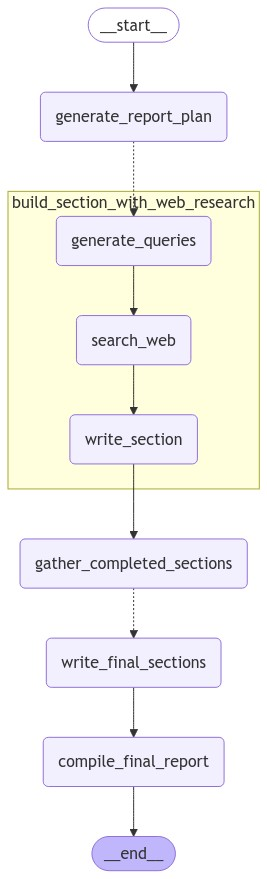

In [27]:
from langgraph.graph import StateGraph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [30]:
report_topic ="What are the types of agent memory?"
report=await graph.ainvoke({"topic":report_topic,
                           "Configuration": Configuration.from_runnable_config()})
report

ValidationError: 1 validation error for Queries
queries
  Input should be a valid list [type=list_type, input_value='["types of agent memory ...ry types and examples"]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type